In [5]:
# -*- coding: utf-8 -*-
import os
import sys

# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
from keras.utils import multi_gpu_model

import numpy as np
from scipy.signal import medfilt
import glob
import matplotlib.pyplot as plt

import librosa
from madmom.audio.signal import *

from model import *
from featureExtraction import *


Using TensorFlow backend.


In [6]:
class Options(object):
    def __init__(self):
        self.num_spec = 513
        self.input_size = 31  # 115
        self.batch_size = 64  # 64
        self.note_res = 8
        self.figureON = False


options = Options()

In [16]:
def spec_extraction(file_name, win_size=31):
#     currentFilePath = str(Path(__file__).resolve().parent)
    # print(currentFilePath)

    x_test = []

    # y, sr = librosa.load(file_name, sr=8000)
    # *********** madmom.Signal() is faster than librosa.load() ***********
    y = Signal(file_name, sample_rate=8000, dtype=np.float32, num_channels=1)
    S = librosa.core.stft(y, n_fft=1024, hop_length=80*1, win_length=1024)

    x_spec = np.abs(S)
    x_spec = librosa.core.power_to_db(x_spec, ref=np.max)
    x_spec = x_spec.astype(np.float32)
    num_frames = x_spec.shape[1]

    # for padding
    padNum = num_frames % win_size
    if padNum != 0:
        len_pad = win_size - padNum
        padding_feature = np.zeros(shape=(513, len_pad))
        x_spec = np.concatenate((x_spec, padding_feature), axis=1)
        num_frames = num_frames + len_pad

    for j in range(0, num_frames, win_size):
        x_test_tmp = x_spec[:, range(j, j + win_size)].T
        x_test.append(x_test_tmp)
    x_test = np.array(x_test)

    # for normalization

    x_train_mean = np.load('./x_data_mean_total_31.npy')
    x_train_std = np.load('./x_data_std_total_31.npy')
    x_test = (x_test-x_train_mean)/(x_train_std+0.0001)
    x_test = x_test[:, :, :, np.newaxis]

    return x_test, x_spec


In [24]:
def main_CS(file_name):

    pitch_range = np.arange(45, 95 + 1.0/options.note_res, 1.0/options.note_res)
    pitch_range = np.concatenate([np.zeros(1), pitch_range])

    '''  Features extraction'''
    X_test, X_spec = spec_extraction(
        file_name=file_name, win_size=options.input_size)

    '''  melody predict'''
    model = melody_ResNet(options)
    model.load_weights('./weights/ResNet_CS.hdf5')
    y_predict = model.predict(X_test, batch_size=options.batch_size, verbose=1)

    y_shape = y_predict.shape
    num_total_frame = y_shape[0]*y_shape[1]
    est_pitch = np.zeros(num_total_frame)
    index_predict = np.zeros(num_total_frame)

    y_predict = np.reshape(y_predict, (num_total_frame, y_shape[2]))

    for i in range(num_total_frame):
        index_predict[i] = np.argmax(y_predict[i, :])
        pitch_MIDI = pitch_range[np.int32(index_predict[i])]
        if pitch_MIDI >= 45 and pitch_MIDI <= 95:
            est_pitch[i] = 2 ** ((pitch_MIDI - 69) / 12.) * 440

    est_pitch = medfilt(est_pitch, 5)
    

#     start = 0
#     end = 1000
#     plt.figure(figsize=(10,7))

#     plt.imshow(X_spec[:,start:end],origin='lower')
#     plt.plot(est_pitch[start:end],'r')


    endpoint = 3000
    ii = (num_total_frame // endpoint)
    for i in range(ii):
        start = endpoint * i
        end = start+ endpoint
        fig = plt.figure(figsize=(20,20))
        plt.imshow(X_spec[:,start:end], origin='lower')
        plt.plot(est_pitch[start:end],'r',linewidth=1)
        fig.tight_layout()

        # plt.savefig('test.pdf', bbox_inches='tight')
        plt.show()

713/713 [==============================] - 1s 2ms/step


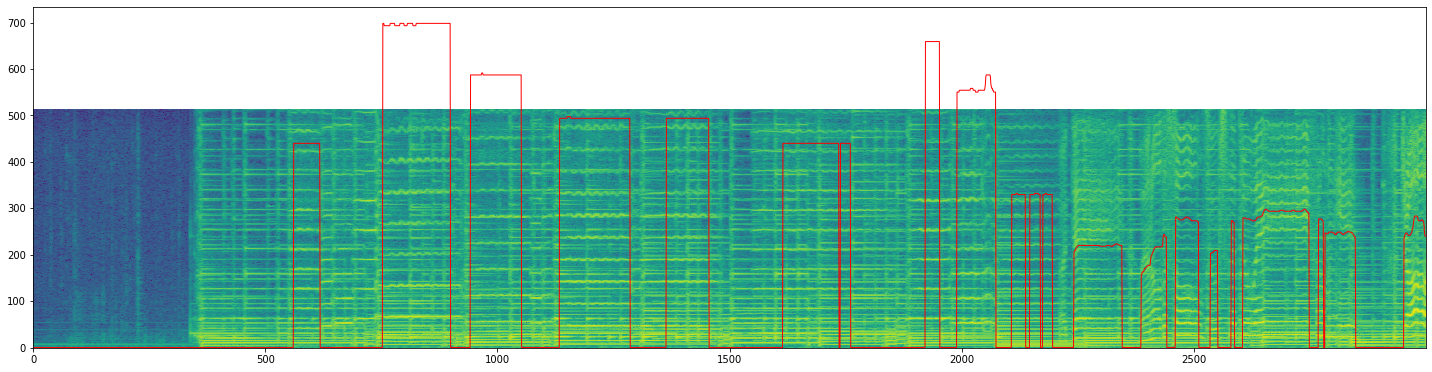

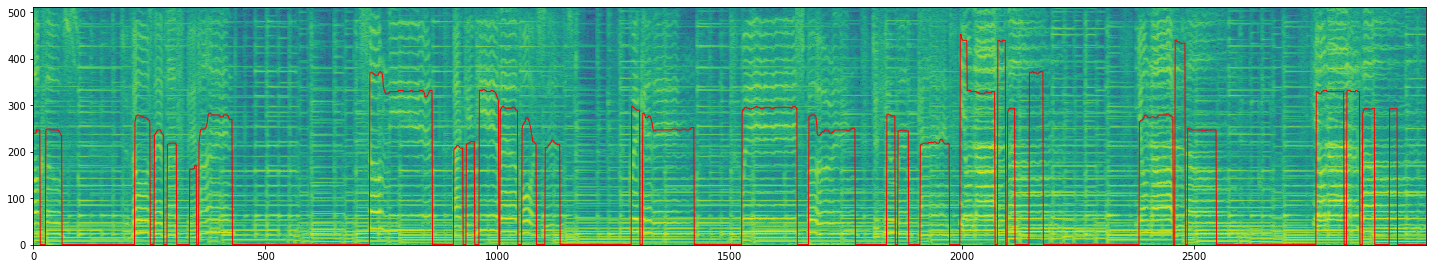

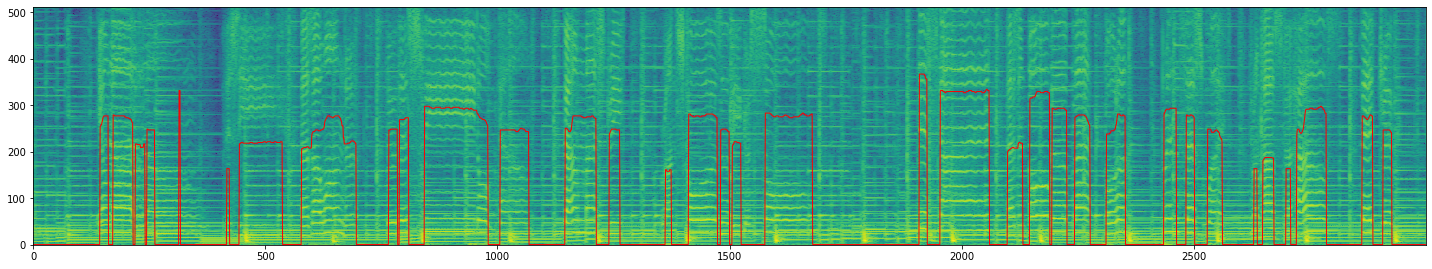

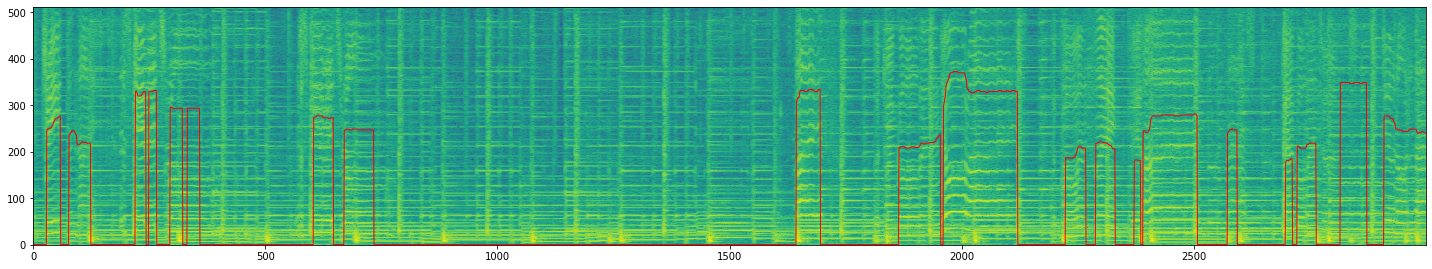

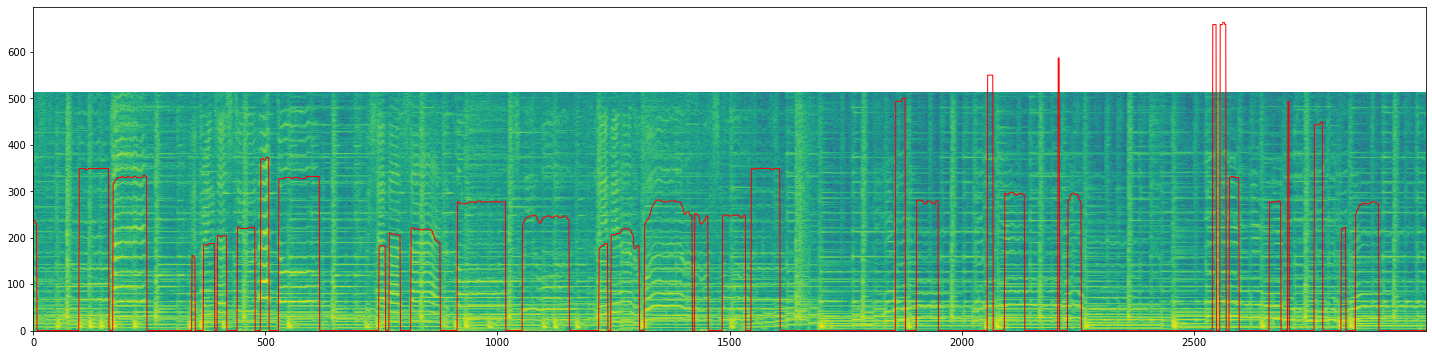

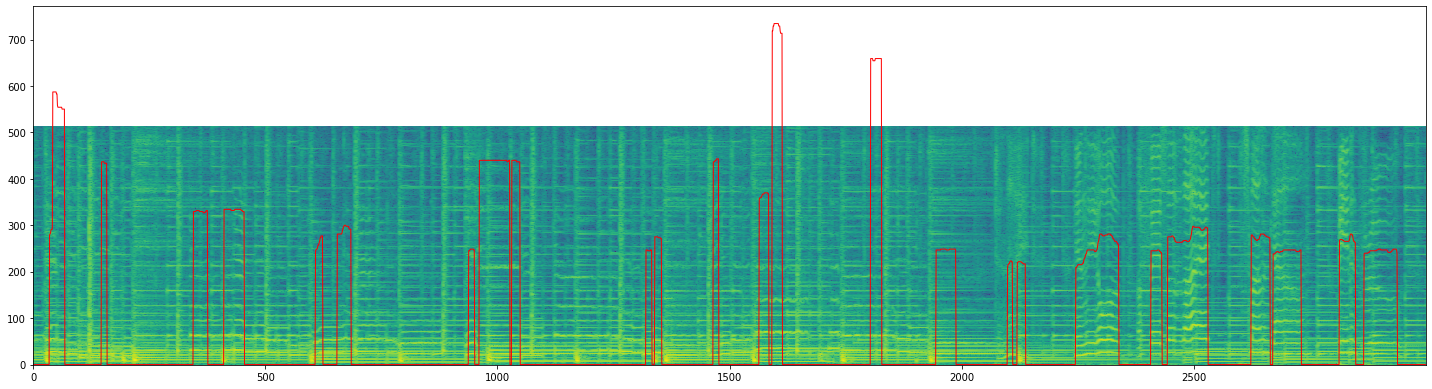

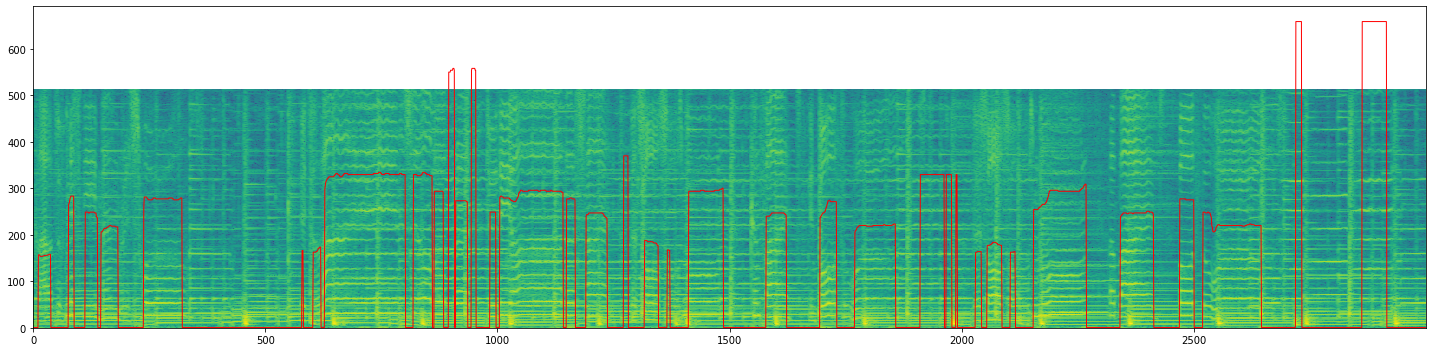

In [25]:
file_name = '/home/keums/project/dataset/musdb18/train/James May - All Souls Moon.stem.mp4'

main_CS(file_name=file_name)
# main_CS('test_audio_file2.wav')